In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
df = pd.read_csv("raw.csv")
df.dropna(inplace=True)
df.drop(columns=["Unnamed: 0", "id"], inplace=True)

In [3]:
from urllib.parse import urlparse
def time_of_day(hour):
    if hour is None:
        return None
    elif 0 <= hour < 5:
        return "past_midnight"
    elif 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 13:
        return "noon"
    elif 13 <= hour < 18:
        return "afternoon"
    else:  
        return "evening"
def add_time_columns(d):
    d['total_minutes'] = d['total_seconds'] / 60
    d['total_hours'] = d['total_seconds'] / 3600

    d[['total_minutes', 'total_hours']] = (
        d[['total_minutes', 'total_hours']].round(3)
    )
    d = d[d["total_seconds"] >= 60]
    return d
df["date_object"] = pd.to_datetime(df["date_object"], utc=True)
df["date_object"] = df["date_object"].dt.tz_convert("Asia/Manila")
df['date'] = df['date_object'].dt.date
df["day_of_week"] = df["date_object"].dt.day_name()
df["day_of_week_num"] = df["date_object"].dt.weekday
df["is_weekend"] = df["day_of_week_num"] >= 5
df["hour"] = df["date_object"].dt.hour
df["time_of_day"] = df["hour"].apply(time_of_day)
df['week_number'] = df['date_object'].dt.isocalendar().week
df['week_type'] = df['is_weekend'].map({
    True: 'weekend',
    False: 'weekday'
})
timeofday_mapping = {
    'past_midnight': 0,
    'morning': 1,
    'noon': 2,
    'afternoon': 3,
    'evening': 4
}

df['timeofday_numeric'] = df['time_of_day'].map(timeofday_mapping)
df = df[df["seconds_elapsed"] != 0]

categorized_urls = pd.read_csv("categorized_urls.csv")
categorized_urls["category"] = categorized_urls['category'].str.lower()
categorized_urls['url'] = categorized_urls['url'].str.lower()

df['url_category'] = df['base_url'].map(categorized_urls.set_index('url')['category'])

df['url_category'] = df['url_category'].replace('work tools', 'developer')

df = df[df['url_category'] != 'adult']
df['url_category'] = df['url_category'].astype("category")

df['url_category_int'] = df['url_category'].cat.codes



In [4]:
df["url_category"].unique()

['entertainment', 'social media', 'developer', 'others', 'games', 'educational']
Categories (6, object): ['developer', 'educational', 'entertainment', 'games', 'others', 'social media']

In [5]:
df.isnull().sum()

base_url             0
full_url             0
date_object          0
seconds_elapsed      0
date                 0
day_of_week          0
day_of_week_num      0
is_weekend           0
hour                 0
time_of_day          0
week_number          0
week_type            0
timeofday_numeric    0
url_category         0
url_category_int     0
dtype: int64

In [6]:
df.describe()

,seconds_elapsed,day_of_week_num,hour,week_number,timeofday_numeric,url_category_int
count,321460.000000,321460.000000,321460.000000,321460.0,321460.000000,321460.000000
mean,3.866189,2.804389,15.477073,15.928234,2.900725,2.965548
std,0.578384,1.992550,6.213269,21.777084,1.316244,1.922010
min,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,4.000000,1.000000,12.000000,2.0,2.000000,2.000000
50%,4.000000,2.000000,16.000000,4.0,3.000000,3.000000
75%,4.000000,5.000000,20.000000,51.0,4.000000,5.000000
max,14.000000,6.000000,23.000000,52.0,4.000000,5.000000


In [7]:
df["base_url"].nunique()

405

In [8]:
total_time = df["seconds_elapsed"].sum()

hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"Total Internet Time: {int(hours)}h {int(minutes)}m {int(seconds)}s")



Total Internet Time: 345h 13m 45s


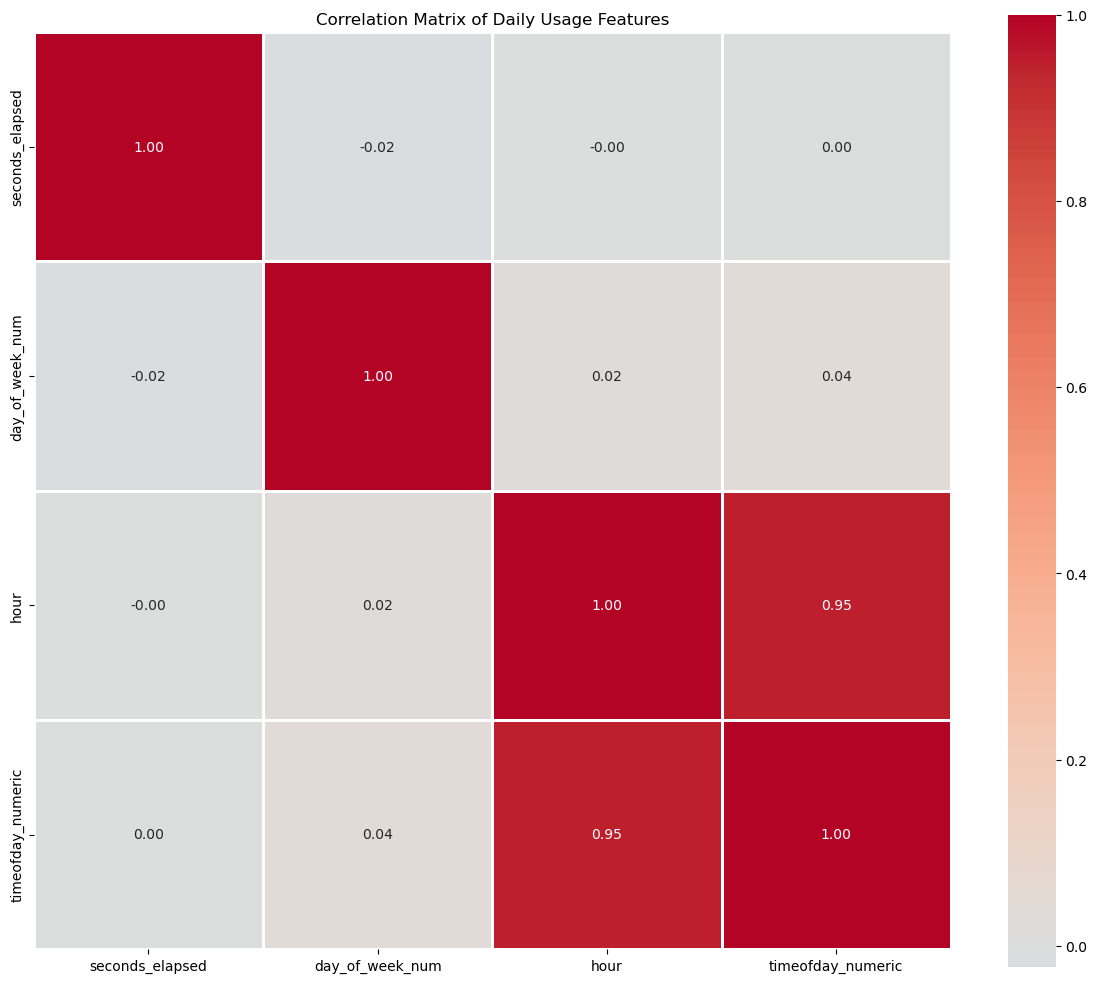

In [9]:
import seaborn as sns

numeric_features = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])

corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=1)
plt.title('Correlation Matrix of Daily Usage Features')
plt.tight_layout()
plt.show()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\1315228672.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("url_category")["seconds_elapsed"]


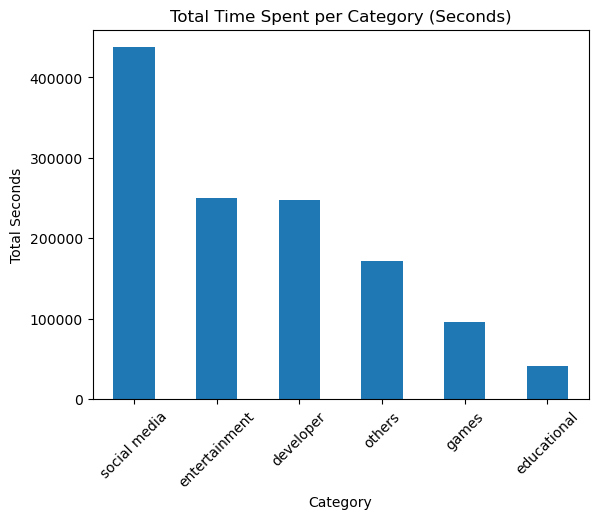

In [10]:
category_total = (
    df.groupby("url_category")["seconds_elapsed"]
      .sum()
      .sort_values(ascending=False)
)

plt.figure()
category_total.plot(kind="bar")
plt.title("Total Time Spent per Category (Seconds)")
plt.xlabel("Category")
plt.ylabel("Total Seconds")
plt.xticks(rotation=45)
plt.show()


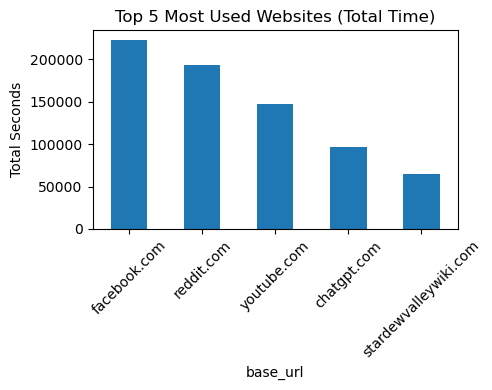

In [11]:
top10 = (
    df.groupby("base_url")["seconds_elapsed"]
      .sum()
      .sort_values(ascending=False)
      .head(5)
)

plt.figure(figsize=(5,4))
top10.plot(kind="bar")
plt.title("Top 5 Most Used Websites (Total Time)")
plt.ylabel("Total Seconds")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


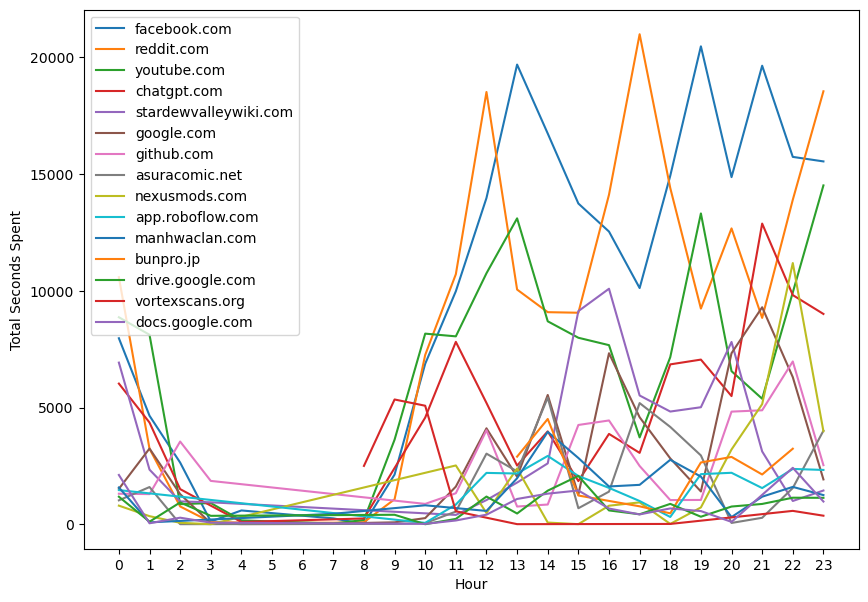

In [12]:
top_sites = (
    df.groupby("base_url")["seconds_elapsed"]
      .sum()
      .nlargest(15)
      .index
)

df_filtered = df[df["base_url"].isin(top_sites)]
line_data = (
    df_filtered.groupby(["hour", "base_url"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

for site in top_sites:
    site_data = line_data[line_data["base_url"] == site]
    plt.plot(site_data["hour"], site_data["seconds_elapsed"], label=site)

plt.xlabel("Hour")
plt.ylabel("Total Seconds Spent")
plt.xticks(range(24))
plt.legend()
plt.show()


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\2634632545.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["hour", "url_category"])["seconds_elapsed"]


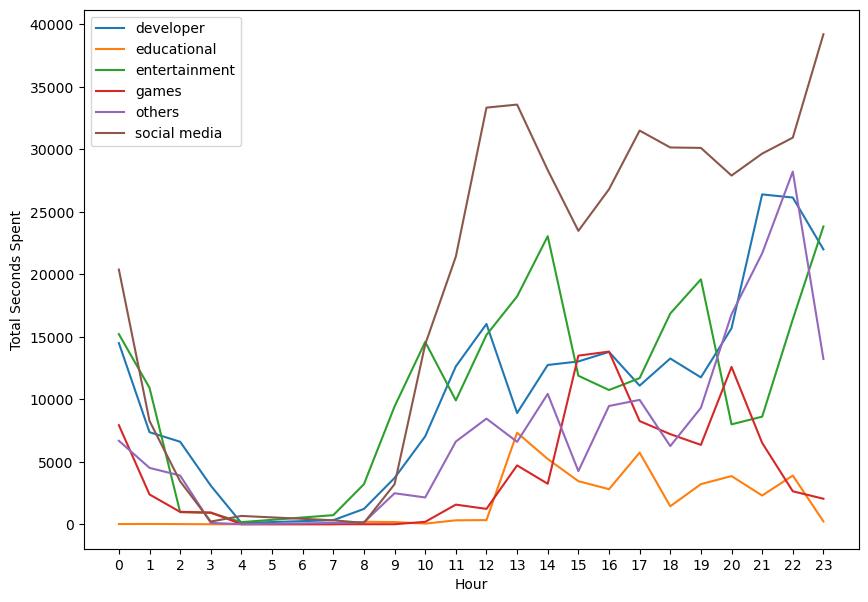

In [13]:
category_hourly = (
    df.groupby(["hour", "url_category"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
plt.figure(figsize=(10, 7))

for category in category_hourly["url_category"].unique():
    cat_data = category_hourly[category_hourly["url_category"] == category]
    plt.plot(cat_data["hour"], cat_data["seconds_elapsed"], label=category)

plt.xlabel("Hour")
plt.ylabel("Total Seconds Spent")
plt.xticks(range(24))
plt.legend()
plt.show()

In [14]:
line_matrix = line_data.pivot(
    index="hour",
    columns="base_url",
    values="seconds_elapsed"
).fillna(0)

print(line_matrix)


base_url  app.roboflow.com  asuracomic.net  bunpro.jp  chatgpt.com  \
hour                                                                 
0                   1463.0          1024.0        0.0       6027.0   
1                      0.0          1594.0        0.0       4358.0   
2                      0.0             3.0        0.0       1506.0   
3                      0.0             0.0        0.0        797.0   
4                      0.0             0.0        0.0         97.0   
7                      0.0            14.0        0.0          0.0   
8                      0.0             0.0        0.0        248.0   
9                      0.0            16.0        0.0          0.0   
10                    58.0            48.0        0.0       4570.0   
11                   844.0           543.0        0.0       7815.0   
12                  2200.0          3025.0        0.0       5198.0   
13                  2174.0          2264.0     2897.0       2514.0   
14                  

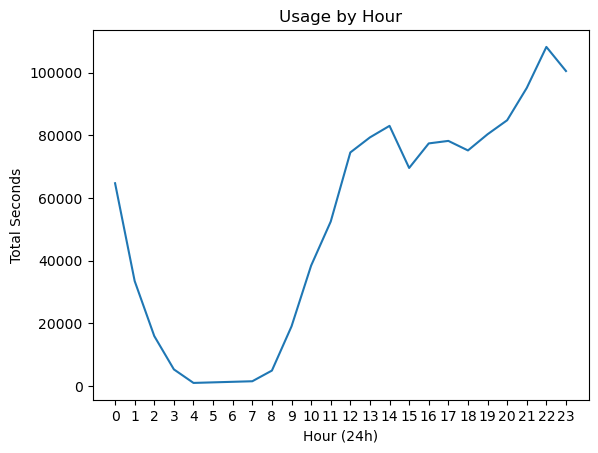

In [15]:
import seaborn as sns

hourly = df.groupby("hour")["seconds_elapsed"].sum()

plt.figure()
hourly.plot()
plt.title("Usage by Hour")
plt.xlabel("Hour (24h)")
plt.ylabel("Total Seconds")
plt.xticks(range(0,24))
plt.show()






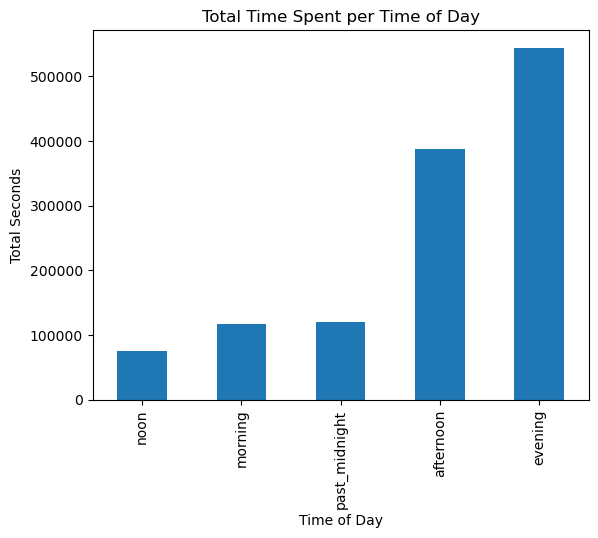

In [16]:
tod = df.groupby("time_of_day")["seconds_elapsed"].sum().sort_values()

plt.figure()
tod.plot(kind="bar")
plt.title("Total Time Spent per Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Total Seconds")
plt.show()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\3060825348.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["time_of_day", "url_category"])["seconds_elapsed"]


<Figure size 640x480 with 0 Axes>

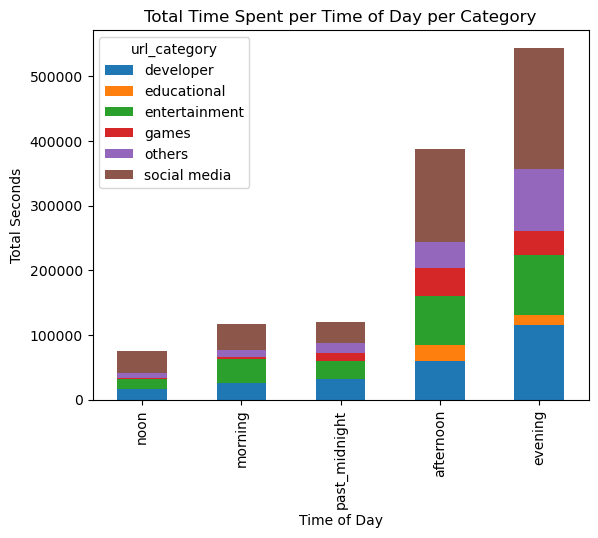

In [17]:
tod_category = (
    df.groupby(["time_of_day", "url_category"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
tod_pivot = tod_category.pivot(
    index="time_of_day",
    columns="url_category",
    values="seconds_elapsed"
).fillna(0)
tod_pivot = tod_pivot.reindex([
    "noon",
    "morning",
    "past_midnight",
    "afternoon",
    "evening"
])

plt.figure()
tod_pivot.plot(kind="bar", stacked=True)
plt.title("Total Time Spent per Time of Day per Category")
plt.xlabel("Time of Day")
plt.ylabel("Total Seconds")
plt.show()


<Figure size 640x480 with 0 Axes>

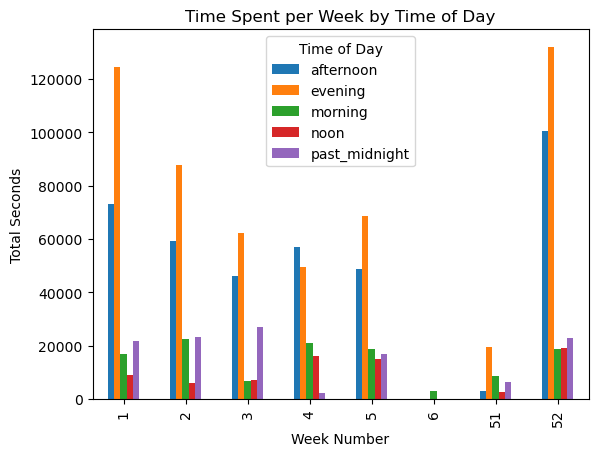

In [18]:
df['week_number'] = df['date_object'].dt.isocalendar().week

tod_week = (
    df.groupby(['week_number', 'time_of_day'])['seconds_elapsed']
      .sum()
      .reset_index()
)

# convert to pivot for plotting
tod_week_pivot = tod_week.pivot(
    index='week_number',
    columns='time_of_day',
    values='seconds_elapsed'
)

plt.figure()
tod_week_pivot.plot(kind="bar")
plt.title("Time Spent per Week by Time of Day")
plt.xlabel("Week Number")
plt.ylabel("Total Seconds")
plt.legend(title="Time of Day")
plt.show()

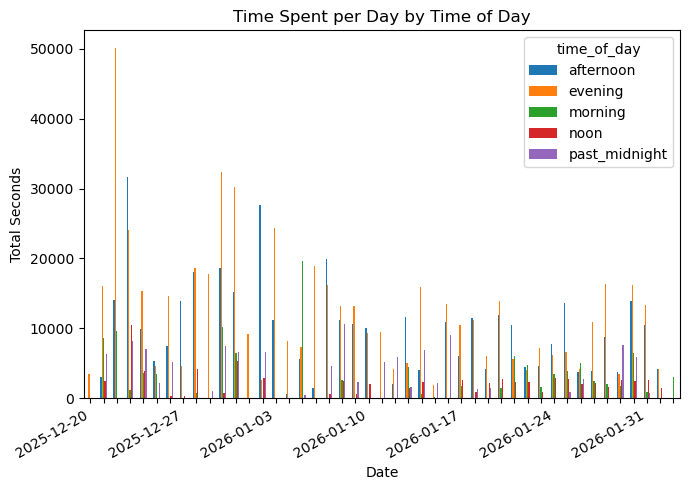

In [19]:
day_tod = (
    df.groupby(['date', 'time_of_day'])['seconds_elapsed']
      .sum()
      .reset_index()
)

day_tod_pivot = day_tod.pivot(
    index='date',
    columns='time_of_day',
    values='seconds_elapsed'
)

ax = day_tod_pivot.plot(kind='bar', figsize=(7,5))

ax.set_title("Time Spent per Day by Time of Day")
ax.set_xlabel("Date")
ax.set_ylabel("Total Seconds")
for i, label in enumerate(ax.xaxis.get_ticklabels()):
    if i % 7 != 0:  # show every 2nd label
        label.set_visible(False)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

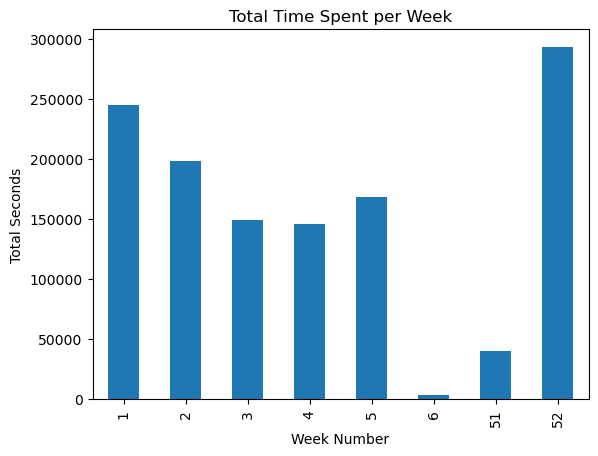

In [20]:
df['week_number'] = df['date_object'].dt.isocalendar().week

week_total = (
    df.groupby('week_number')['seconds_elapsed']
      .sum()
      .sort_index()
)

plt.figure()
week_total.plot(kind='bar')
plt.title("Total Time Spent per Week")
plt.xlabel("Week Number")
plt.ylabel("Total Seconds")
plt.show()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\2869728542.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["week_number", "url_category"])["seconds_elapsed"]


<Figure size 640x480 with 0 Axes>

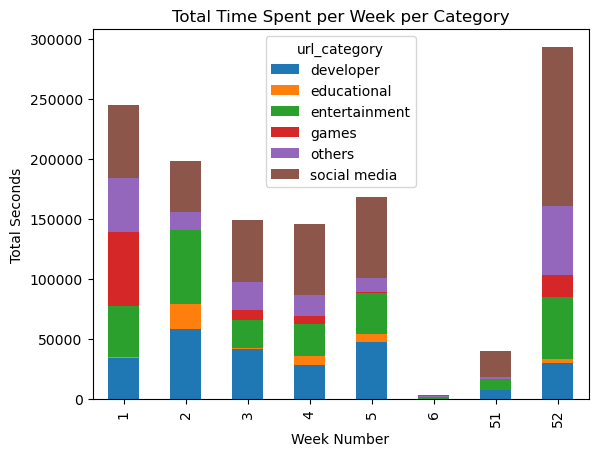

In [21]:
week_category_total = (
    df.groupby(["week_number", "url_category"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
week_category_pivot = week_category_total.pivot(
    index="week_number",
    columns="url_category",
    values="seconds_elapsed"
).fillna(0)
plt.figure()
week_category_pivot.plot(kind="bar", stacked=True)
plt.title("Total Time Spent per Week per Category")
plt.xlabel("Week Number")
plt.ylabel("Total Seconds")
plt.show()


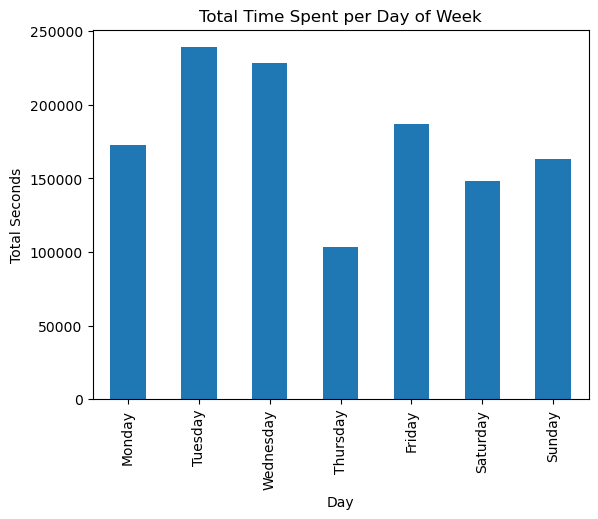

In [22]:
dow = df.groupby("day_of_week")["seconds_elapsed"].sum()

dow = dow.reindex([
    "Monday","Tuesday","Wednesday",
    "Thursday","Friday","Saturday","Sunday"
])

plt.figure()
dow.plot(kind="bar")
plt.title("Total Time Spent per Day of Week")
plt.xlabel("Day")
plt.ylabel("Total Seconds")
plt.show()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\1402166764.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["day_of_week", "url_category"])["seconds_elapsed"]


<Figure size 640x480 with 0 Axes>

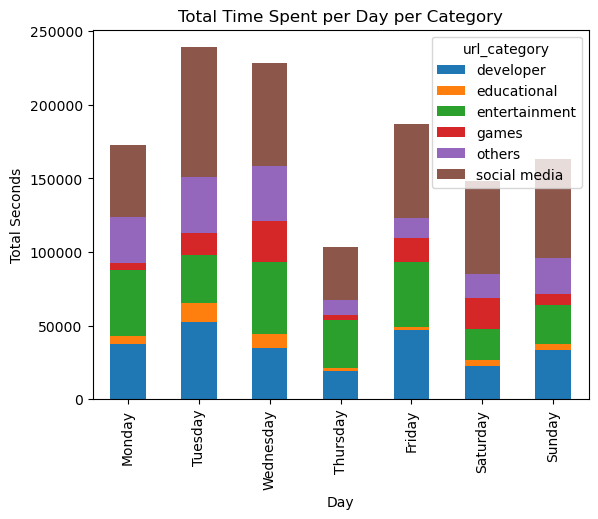

In [23]:
dow_category = (
    df.groupby(["day_of_week", "url_category"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
dow_pivot = dow_category.pivot(
    index="day_of_week",
    columns="url_category",
    values="seconds_elapsed"
).fillna(0)
dow_pivot = dow_pivot.reindex([
    "Monday","Tuesday","Wednesday",
    "Thursday","Friday","Saturday","Sunday"
])
plt.figure()
dow_pivot.plot(kind="bar", stacked=True)
plt.title("Total Time Spent per Day per Category")
plt.xlabel("Day")
plt.ylabel("Total Seconds")
plt.show()


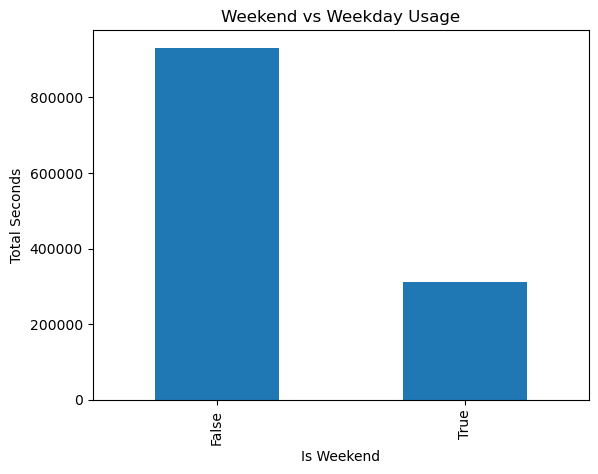

In [24]:
weekend = df.groupby("is_weekend")["seconds_elapsed"].sum()

plt.figure()
weekend.plot(kind="bar")
plt.title("Weekend vs Weekday Usage")
plt.xlabel("Is Weekend")
plt.ylabel("Total Seconds")
plt.show()


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\2090413893.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["is_weekend", "url_category"])["seconds_elapsed"]


<Figure size 640x480 with 0 Axes>

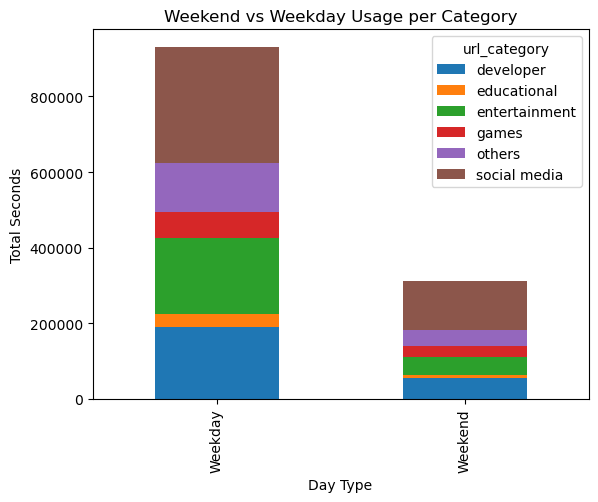

In [25]:
weekend_category = (
    df.groupby(["is_weekend", "url_category"])["seconds_elapsed"]
      .sum()
      .reset_index()
)
weekend_pivot = weekend_category.pivot(
    index="is_weekend",
    columns="url_category",
    values="seconds_elapsed"
).fillna(0)
weekend_pivot.index = weekend_pivot.index.map({
    False: "Weekday",
    True: "Weekend"
})
plt.figure()
weekend_pivot.plot(kind="bar", stacked=True)
plt.title("Weekend vs Weekday Usage per Category")
plt.xlabel("Day Type")
plt.ylabel("Total Seconds")
plt.show()


# line graph:

x = number of hours/days

y = website 

In [26]:
print("Shape:")
print(df.shape)

print("\nColumns:")
print(df.columns)

print("\nData Types:")
print(df.dtypes)



Shape:
(321460, 15)

Columns:
Index(['base_url', 'full_url', 'date_object', 'seconds_elapsed', 'date',
       'day_of_week', 'day_of_week_num', 'is_weekend', 'hour', 'time_of_day',
       'week_number', 'week_type', 'timeofday_numeric', 'url_category',
       'url_category_int'],
      dtype='object')

Data Types:
base_url                                  object
full_url                                  object
date_object          datetime64[ns, Asia/Manila]
seconds_elapsed                            int64
date                                      object
day_of_week                               object
day_of_week_num                            int32
is_weekend                                  bool
hour                                       int32
time_of_day                               object
week_number                               UInt32
week_type                                 object
timeofday_numeric                          int64
url_category                            categor

In [27]:
daily_total = (
    df.groupby(['date', 'day_of_week', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']
      .sum()
      .rename(columns={'seconds_elapsed': 'total_seconds'})
)
daily_total = add_time_columns(daily_total)

skew_value = daily_total["total_seconds"].skew()
print("Skewness:", skew_value)


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\3457520150.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['date', 'day_of_week', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']


Skewness: 3.258771382674187


In [28]:
day_time_total = (
    df.groupby(['date', 'time_of_day', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']
      .sum()
      .rename(columns={'seconds_elapsed': 'total_seconds'})
)
day_time_total = add_time_columns(day_time_total)
skew_value = day_time_total["total_seconds"].skew()
print("Skewness:", skew_value)



Skewness: 3.9018604667114047


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\2131596228.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['date', 'time_of_day', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']


In [29]:
week_summary = (
    df.groupby(['week_number', 'week_type', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']
      .sum()
      .rename(columns={'seconds_elapsed': 'total_seconds'})
)
week_summary = add_time_columns(week_summary)
week_summary = week_summary.sort_values(
    ['week_number','week_type','base_url']
)

skew_value = week_summary["total_seconds"].skew()
print("Skewness:", skew_value)


Skewness: 4.516215234397298


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\326173398.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['week_number', 'week_type', 'base_url', 'url_category'], as_index=False)['seconds_elapsed']


In [30]:
df.describe()

,seconds_elapsed,day_of_week_num,hour,week_number,timeofday_numeric,url_category_int
count,321460.000000,321460.000000,321460.000000,321460.0,321460.000000,321460.000000
mean,3.866189,2.804389,15.477073,15.928234,2.900725,2.965548
std,0.578384,1.992550,6.213269,21.777084,1.316244,1.922010
min,1.000000,0.000000,0.000000,1.0,0.000000,0.000000
25%,4.000000,1.000000,12.000000,2.0,2.000000,2.000000
50%,4.000000,2.000000,16.000000,4.0,3.000000,3.000000
75%,4.000000,5.000000,20.000000,51.0,4.000000,5.000000
max,14.000000,6.000000,23.000000,52.0,4.000000,5.000000


In [31]:
daily_total.describe()

,total_seconds,total_minutes,total_hours
count,724.000000,724.000000,724.000000
mean,1702.687845,28.378119,0.472965
std,2880.694814,48.011574,0.800183
min,60.000000,1.000000,0.017000
25%,156.000000,2.600250,0.043500
50%,496.000000,8.266500,0.137500
75%,1952.750000,32.545500,0.542250
max,22192.000000,369.867000,6.164000


In [32]:
day_time_total.describe()

,total_seconds,total_minutes,total_hours
count,1177.000000,1177.000000,1177.000000
mean,1042.954970,17.382599,0.289699
std,1613.415704,26.890260,0.448169
min,60.000000,1.000000,0.017000
25%,160.000000,2.667000,0.044000
50%,430.000000,7.167000,0.119000
75%,1265.000000,21.083000,0.351000
max,16194.000000,269.900000,4.498000


In [33]:
week_summary.describe()

,week_number,total_seconds,total_minutes,total_hours
count,445.0,445.000000,445.000000,445.000000
mean,14.260674,2777.289888,46.288173,0.771434
std,20.628403,6303.009024,105.050158,1.750833
min,1.0,60.000000,1.000000,0.017000
25%,2.0,145.000000,2.417000,0.040000
50%,4.0,446.000000,7.433000,0.124000
75%,5.0,2163.000000,36.050000,0.601000
max,52.0,58578.000000,976.300000,16.272000


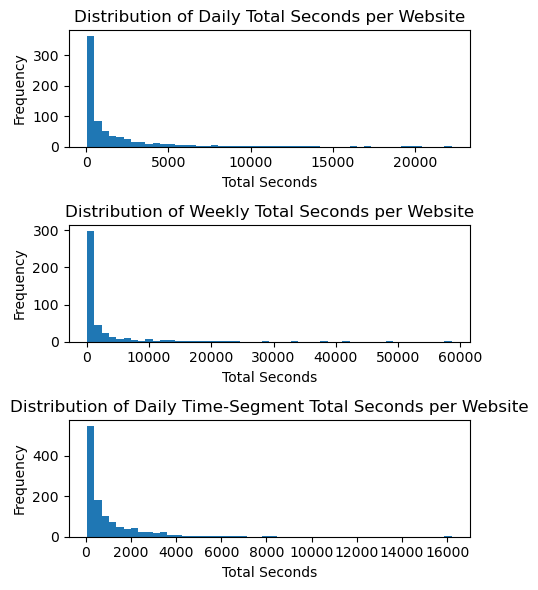

In [34]:
fig, axes = plt.subplots(3, 1, figsize=(5, 6))

# 1️⃣ Daily distribution
axes[0].hist(daily_total["total_seconds"], bins=50)
axes[0].set_title("Distribution of Daily Total Seconds per Website")
axes[0].set_xlabel("Total Seconds")
axes[0].set_ylabel("Frequency")

# 2️⃣ Weekly distribution
axes[1].hist(week_summary["total_seconds"], bins=50)
axes[1].set_title("Distribution of Weekly Total Seconds per Website")
axes[1].set_xlabel("Total Seconds")
axes[1].set_ylabel("Frequency")

# 3️⃣ Daily + Time of Day distribution
axes[2].hist(day_time_total["total_seconds"], bins=50)
axes[2].set_title("Distribution of Daily Time-Segment Total Seconds per Website")
axes[2].set_xlabel("Total Seconds")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [35]:
df["url_category"].unique()
# 'entertainment', 'social media', 'developer', 'others', 'games', 'educational'

['entertainment', 'social media', 'developer', 'others', 'games', 'educational']
Categories (6, object): ['developer', 'educational', 'entertainment', 'games', 'others', 'social media']

In [36]:
daily_total.groupby('url_category')['total_seconds'].describe()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\1173601970.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daily_total.groupby('url_category')['total_seconds'].describe()


,count,mean,std,min,25%,50%,75%,max
url_category,,,,,,,,
developer,186.0,1314.559140,2034.484486,60.0,146.50,484.5,1486.50,11528.0
educational,34.0,1169.647059,2061.468289,62.0,144.25,312.5,1333.25,8899.0
entertainment,137.0,1817.233577,2515.042174,63.0,210.00,586.0,2318.00,13480.0
games,65.0,1453.492308,3107.005789,62.0,114.00,250.0,1546.00,19160.0
others,188.0,892.728723,1668.400584,60.0,126.50,306.0,904.00,13808.0
social media,114.0,3835.078947,4618.108589,68.0,722.75,2217.5,4719.75,22192.0


In [37]:
day_time_total.groupby('url_category')['total_seconds'].describe()

C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\2183228797.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_time_total.groupby('url_category')['total_seconds'].describe()


,count,mean,std,min,25%,50%,75%,max
url_category,,,,,,,,
developer,287.0,846.118467,1295.831650,60.0,129.5,320.0,929.50,11304.0
educational,39.0,1018.974359,1705.460726,62.0,150.0,336.0,1281.00,8131.0
entertainment,228.0,1088.815789,1420.758227,63.0,225.0,582.0,1499.25,13480.0
games,78.0,1210.192308,1975.336809,62.0,124.0,300.0,1522.50,11838.0
others,242.0,685.491736,1201.741006,60.0,118.0,230.5,735.00,10328.0
social media,303.0,1440.422442,2051.636031,60.0,323.5,702.0,1696.50,16194.0


In [38]:
week_summary.groupby('url_category')['total_seconds'].describe()


C:\Users\rainn\AppData\Local\Temp\ipykernel_6872\4150081247.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  week_summary.groupby('url_category')['total_seconds'].describe()


,count,mean,std,min,25%,50%,75%,max
url_category,,,,,,,,
developer,115.0,2136.791304,3708.956659,60.0,153.0,498.0,2156.50,18018.0
educational,26.0,1531.692308,4032.986821,62.0,149.0,400.0,940.75,20744.0
entertainment,75.0,3328.533333,6117.525554,63.0,283.0,586.0,2603.50,33000.0
games,55.0,1722.181818,5710.526431,62.0,123.0,264.0,976.00,41614.0
others,129.0,1307.395349,2641.779559,60.0,118.0,291.0,1154.00,19264.0
social media,45.0,9718.333333,13161.962777,68.0,567.0,3721.0,13466.00,58578.0


In [39]:
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import kruskal
def test_anova_across_categories(df_grouped):
    entertainment = df_grouped[df_grouped['url_category'] == 'entertainment']['total_seconds']
    social_media  = df_grouped[df_grouped['url_category'] == 'social media']['total_seconds']
    developer     = df_grouped[df_grouped['url_category'] == 'developer']['total_seconds']
    others        = df_grouped[df_grouped['url_category'] == 'others']['total_seconds']
    games         = df_grouped[df_grouped['url_category'] == 'games']['total_seconds']
    educational   = df_grouped[df_grouped['url_category'] == 'educational']['total_seconds']

    stat, p_value = f_oneway(
        entertainment,
        social_media,
        developer,
        others,
        games,
        educational
    )

    print("ANOVA Across Categories")
    print(f"F-statistic: {stat:.4f}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("Significant difference between categories.")
    else:
        print("No significant difference between categories.")





def test_kruskal_across_categories(df_grouped):
    entertainment = df_grouped[df_grouped['url_category'] == 'entertainment']['total_seconds']
    social_media  = df_grouped[df_grouped['url_category'] == 'social media']['total_seconds']
    developer     = df_grouped[df_grouped['url_category'] == 'developer']['total_seconds']
    others        = df_grouped[df_grouped['url_category'] == 'others']['total_seconds']
    games         = df_grouped[df_grouped['url_category'] == 'games']['total_seconds']
    educational   = df_grouped[df_grouped['url_category'] == 'educational']['total_seconds']

    stat, p_value = kruskal(
        entertainment,
        social_media,
        developer,
        others,
        games,
        educational
    )

    print("Kruskal–Wallis Across Categories")
    print(f"H-statistic: {stat:.4f}")
    print(f"P-value: {p_value}")

    if p_value < 0.05:
        print("Significant difference between categories.")
    else:
        print("No significant difference between categories.")



# One way anova

In [40]:
test_anova_across_categories(daily_total)

ANOVA Across Categories
F-statistic: 18.5148
P-value: 2.5346863750143165e-17
Significant difference between categories.


In [41]:
test_anova_across_categories(day_time_total)

ANOVA Across Categories
F-statistic: 7.3048
P-value: 9.446023081230453e-07
Significant difference between categories.


In [42]:
test_anova_across_categories(week_summary)

ANOVA Across Categories
F-statistic: 15.3042
P-value: 7.066656170233926e-14
Significant difference between categories.


# Kruskal

In [43]:
test_kruskal_across_categories(daily_total)

Kruskal–Wallis Across Categories
H-statistic: 85.1238
P-value: 7.091213645004626e-17
Significant difference between categories.


In [44]:
test_kruskal_across_categories(day_time_total)

Kruskal–Wallis Across Categories
H-statistic: 85.9967
P-value: 4.6521226061100776e-17
Significant difference between categories.


In [45]:
test_kruskal_across_categories(week_summary)

Kruskal–Wallis Across Categories
H-statistic: 45.9848
P-value: 9.146985697843978e-09
Significant difference between categories.


In [46]:
import scikit_posthocs as sp
# padj​=min(1,m×p)
def posthoc_dunn_test(df_grouped, title):
    data = df_grouped[['url_category', 'total_seconds']]
    
    dunn = sp.posthoc_dunn(
        data,
        val_col='total_seconds',
        group_col='url_category',
        p_adjust='bonferroni'
    )

    plt.figure(figsize=(8,6))
    sns.heatmap(
        dunn,
        annot=True,
        cmap="coolwarm_r",
        cbar_kws={'label': 'Adjusted p-value'}
    )
    
    plt.title("Dunn Post-hoc Test (Bonferroni) "+title )
    plt.tight_layout()
    plt.show()

    return dunn

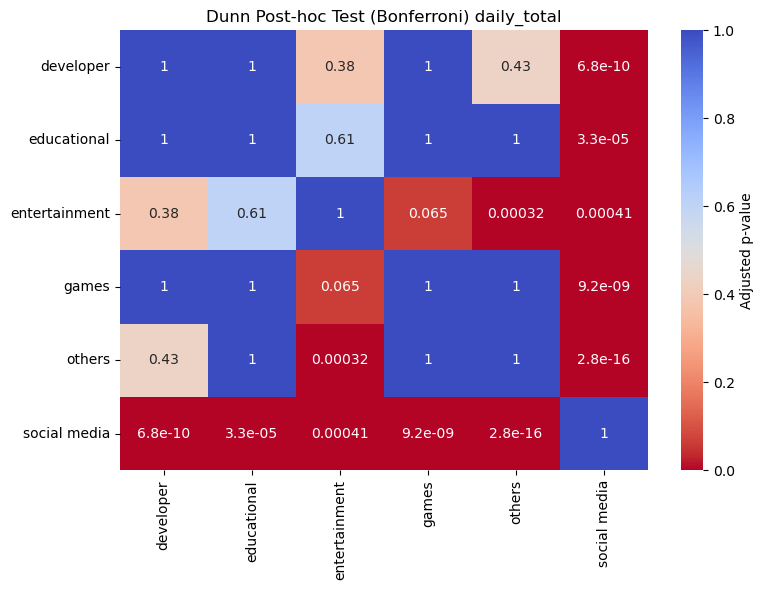

,developer,educational,entertainment,games,others,social media
developer,1.000000e+00,1.000000,0.382824,1.000000e+00,4.346716e-01,6.833500e-10
educational,1.000000e+00,1.000000,0.605066,1.000000e+00,1.000000e+00,3.338437e-05
entertainment,3.828239e-01,0.605066,1.000000,6.463081e-02,3.221083e-04,4.096564e-04
games,1.000000e+00,1.000000,0.064631,1.000000e+00,1.000000e+00,9.153560e-09
others,4.346716e-01,1.000000,0.000322,1.000000e+00,1.000000e+00,2.827097e-16
social media,6.833500e-10,0.000033,0.000410,9.153560e-09,2.827097e-16,1.000000e+00


In [47]:
dunn1 = posthoc_dunn_test(daily_total, "daily_total")
dunn1

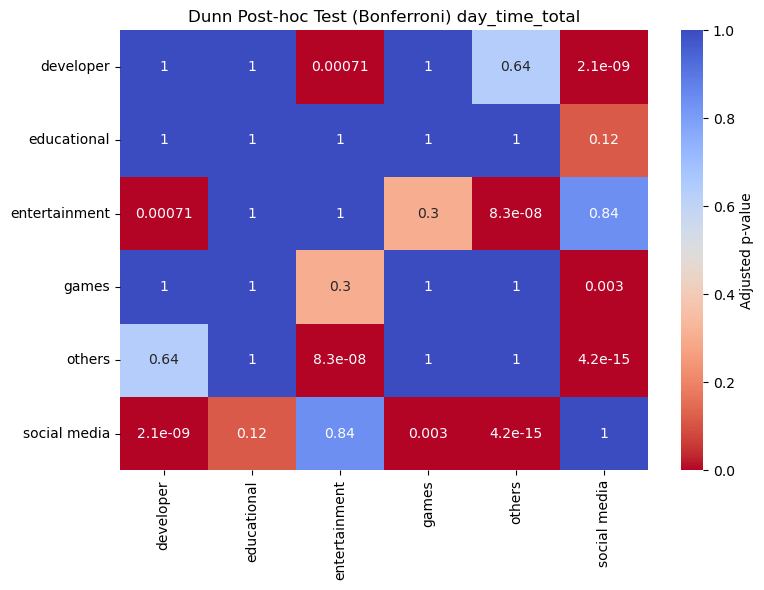

,developer,educational,entertainment,games,others,social media
developer,1.000000e+00,1.00000,7.105871e-04,1.000000,6.358236e-01,2.123935e-09
educational,1.000000e+00,1.00000,1.000000e+00,1.000000,1.000000e+00,1.157297e-01
entertainment,7.105871e-04,1.00000,1.000000e+00,0.301903,8.328490e-08,8.427771e-01
games,1.000000e+00,1.00000,3.019030e-01,1.000000,1.000000e+00,2.993890e-03
others,6.358236e-01,1.00000,8.328490e-08,1.000000,1.000000e+00,4.157028e-15
social media,2.123935e-09,0.11573,8.427771e-01,0.002994,4.157028e-15,1.000000e+00


In [48]:
dunn2 = posthoc_dunn_test(day_time_total, "day_time_total")
dunn2

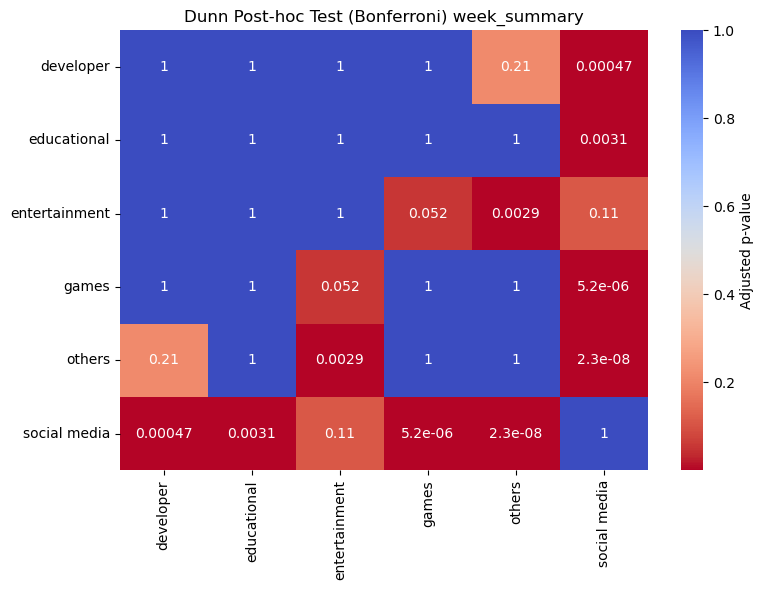

,developer,educational,entertainment,games,others,social media
developer,1.000000,1.000000,1.000000,1.000000,2.142955e-01,4.681415e-04
educational,1.000000,1.000000,1.000000,1.000000,1.000000e+00,3.075595e-03
entertainment,1.000000,1.000000,1.000000,0.052068,2.939646e-03,1.098371e-01
games,1.000000,1.000000,0.052068,1.000000,1.000000e+00,5.177934e-06
others,0.214295,1.000000,0.002940,1.000000,1.000000e+00,2.250133e-08
social media,0.000468,0.003076,0.109837,0.000005,2.250133e-08,1.000000e+00


In [49]:
dunn3 = posthoc_dunn_test(week_summary, "week_summary")
dunn3

In [50]:
len(df)

321460